In [43]:
from textblob import TextBlob
import requests
import pandas as pd
import json
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pandas as pd
import json
import datetime as dt
import numpy as np
from scipy.stats import ks_2samp
import numpy as np
import matplotlib.patches as patches
import seaborn as sns
from pytrends.request import TrendReq
import pandas as pd
from textblob import TextBlob
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.functional import softmax
import torch
from collections import Counter
import re
from scipy import stats
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy
import matplotlib as mpl

# Set the font size globally
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 16

mpl.rcParams['axes.titlesize'] = 16
def add_weekday_month_names(df):
    # Ensure 'created_at' is a datetime column
    df['created_at'] = pd.to_datetime(df['created_at'])

    # Extract the weekday and month
    df['weekday'] = df['created_at'].dt.weekday
    df['month'] = df['created_at'].dt.month

    # Weekday and month name mappings
    weekday_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
                     4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
    month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 
                   5: 'May', 6: 'June', 7: 'July', 8: 'August', 
                   9: 'September', 10: 'October', 11: 'November', 12: 'December'}

    # Convert weekday and month numbers to names
    df['weekday'] = df['weekday'].map(weekday_names)
    df['month'] = df['month'].map(month_names)

    return df



In [22]:
# relative ctr day, relative ctr to impression range (sensitivity),click,ctr
# analyze share image and share text (if available)
# impressions tell us something about the marketing strategy - they correlate with new users, weekend downtime
# polarity,subjectivity
# Assumptions about the data and limitations
# Facebook algorithm share
#Share text and share image can lead to impressions and ctr

# we don't use image_id, and we don't control share text, variation a small
# i treat them just as articles, as they were assigned to random people

# Interptation, how long did tests last, these are not artciles



# The decisionmaking behind A-B test

# The causal inference hard because of external traffic

# If assumptions that test are close to time, first artciles should have garneded more views (check), equal in duration

# I aggreagted that each article is for itself

In [23]:
analysis_start_date = '2013-01-01'
analysis_end_date = '2015-04-30'


In [24]:
df = pd.read_csv('packages.csv')
df = df.drop(['first_place','winner','slug','share_text','share_image'],axis=1 )
# We only have the testing week, but not the exact day
df['lede']=df['lede'].str.replace('</p>', '', regex=False).str.replace('<p>', '', regex=False)
df['test_week'] = pd.to_datetime(df['test_week'], format='%Y-%m-%d')
df['created_at']= pd.to_datetime(df['created_at'], format='%Y-%m-%d')
df['combined_text'] = df[['headline','lede']].apply(lambda x: ' '.join(x.dropna().values.tolist()), axis=1) 
df['cleaned_text'] = df['combined_text'].str.replace('<br>', '', regex=False)
nan_counts = df['cleaned_text'].isna().sum()
df =  add_weekday_month_names(df)
# If there are any NaNs, we will replace them with a blank string to avoid errors during text processing
if nan_counts > 0:
    df['cleaned_text'] = df['cleaned_text'].fillna('')
    
df['ctr'] = df['clicks']/df['impressions']

#df['polarity']

#measures = ['impressions','clicks','ctr']
#for measure in measures:
#    df[measure] = (df[measure] - df[measure].min() )/ (df[measure].max() - df[measure].min())

In [25]:
excerpt_df = df['excerpt'].value_counts()/len(df['excerpt'])
excerpt_df

Things that matter. Pass 'em on.                                                          0.505407
Things that matter. Pass 'em on.                                                          0.003289
Things that matter. Pass 'em on. #PromotedPost                                            0.002845
#PromotedPost Things that matter. Pass 'em on.                                            0.001552
Stories that matter. Pass them on and on.                                                 0.001200
                                                                                            ...   
There’s something you should watch before you Instagram your 4th of July                  0.000007
Chemistry isn't the only way to drastically impact medical science.                       0.000007
I think it's safe to say this is a technique that's about to catch on.                    0.000007
It's possible to completely change medical science without actually doing any science.    0.000007
What if be

# Descriptive Statistics

In [26]:
descriptive_stats = df[['impressions', 'clicks', 'ctr']].describe()

# Print the descriptive statistics
print(descriptive_stats)

         impressions         clicks            ctr
count  150817.000000  150817.000000  150817.000000
mean     3569.046447      54.255648       0.015789
std      1435.995922      45.521282       0.012371
min         1.000000       0.000000       0.000000
25%      2745.000000      25.000000       0.007458
50%      3117.000000      42.000000       0.012509
75%      4089.000000      70.000000       0.020386
max     36908.000000     975.000000       0.183401


### Within test_id variations and the importance of image_id

Make a bit better measures, small variatons means that the lack of image_id is bearable

In [7]:
range_imp_test_id = {}
range_clicks_test_id = {}
range_ctr_test_id = {}
n_unique_cleaned_text_test_id = {}
n_unique_image_test_id = {}
for i, test_id in enumerate(df['test_id'].unique()):
    print(i,len(df['test_id'].unique()))
    test_df = df[df['test_id'] == test_id]
    range_imp_test_id[test_id] = (test_df['impressions'].max() - test_df['impressions'].min())
    range_clicks_test_id[test_id] = (test_df['clicks'].max() - test_df['clicks'].min())
    range_ctr_test_id[test_id] = (test_df['ctr'].max() - test_df['ctr'].min())
    n_unique_cleaned_text_test_id[test_id] =  len(test_df['cleaned_text'])
    n_unique_image_test_id[test_id] =  len(test_df['image_id'])

0 32487
1 32487
2 32487
3 32487
4 32487
5 32487
6 32487
7 32487
8 32487
9 32487
10 32487
11 32487
12 32487
13 32487
14 32487
15 32487
16 32487
17 32487
18 32487
19 32487
20 32487
21 32487
22 32487
23 32487
24 32487
25 32487
26 32487
27 32487
28 32487
29 32487
30 32487
31 32487
32 32487
33 32487
34 32487
35 32487
36 32487
37 32487
38 32487
39 32487
40 32487
41 32487
42 32487
43 32487
44 32487
45 32487
46 32487
47 32487
48 32487
49 32487
50 32487
51 32487
52 32487
53 32487
54 32487
55 32487
56 32487
57 32487
58 32487
59 32487
60 32487
61 32487
62 32487
63 32487
64 32487
65 32487
66 32487
67 32487
68 32487
69 32487
70 32487
71 32487
72 32487
73 32487
74 32487
75 32487
76 32487
77 32487
78 32487
79 32487
80 32487
81 32487
82 32487
83 32487
84 32487
85 32487
86 32487
87 32487
88 32487
89 32487
90 32487
91 32487
92 32487
93 32487
94 32487
95 32487
96 32487
97 32487
98 32487
99 32487
100 32487
101 32487
102 32487
103 32487
104 32487
105 32487
106 32487
107 32487
108 32487
109 32487
110 32487


839 32487
840 32487
841 32487
842 32487
843 32487
844 32487
845 32487
846 32487
847 32487
848 32487
849 32487
850 32487
851 32487
852 32487
853 32487
854 32487
855 32487
856 32487
857 32487
858 32487
859 32487
860 32487
861 32487
862 32487
863 32487
864 32487
865 32487
866 32487
867 32487
868 32487
869 32487
870 32487
871 32487
872 32487
873 32487
874 32487
875 32487
876 32487
877 32487
878 32487
879 32487
880 32487
881 32487
882 32487
883 32487
884 32487
885 32487
886 32487
887 32487
888 32487
889 32487
890 32487
891 32487
892 32487
893 32487
894 32487
895 32487
896 32487
897 32487
898 32487
899 32487
900 32487
901 32487
902 32487
903 32487
904 32487
905 32487
906 32487
907 32487
908 32487
909 32487
910 32487
911 32487
912 32487
913 32487
914 32487
915 32487
916 32487
917 32487
918 32487
919 32487
920 32487
921 32487
922 32487
923 32487
924 32487
925 32487
926 32487
927 32487
928 32487
929 32487
930 32487
931 32487
932 32487
933 32487
934 32487
935 32487
936 32487
937 32487
938 32487


1600 32487
1601 32487
1602 32487
1603 32487
1604 32487
1605 32487
1606 32487
1607 32487
1608 32487
1609 32487
1610 32487
1611 32487
1612 32487
1613 32487
1614 32487
1615 32487
1616 32487
1617 32487
1618 32487
1619 32487
1620 32487
1621 32487
1622 32487
1623 32487
1624 32487
1625 32487
1626 32487
1627 32487
1628 32487
1629 32487
1630 32487
1631 32487
1632 32487
1633 32487
1634 32487
1635 32487
1636 32487
1637 32487
1638 32487
1639 32487
1640 32487
1641 32487
1642 32487
1643 32487
1644 32487
1645 32487
1646 32487
1647 32487
1648 32487
1649 32487
1650 32487
1651 32487
1652 32487
1653 32487
1654 32487
1655 32487
1656 32487
1657 32487
1658 32487
1659 32487
1660 32487
1661 32487
1662 32487
1663 32487
1664 32487
1665 32487
1666 32487
1667 32487
1668 32487
1669 32487
1670 32487
1671 32487
1672 32487
1673 32487
1674 32487
1675 32487
1676 32487
1677 32487
1678 32487
1679 32487
1680 32487
1681 32487
1682 32487
1683 32487
1684 32487
1685 32487
1686 32487
1687 32487
1688 32487
1689 32487
1690 32487

2352 32487
2353 32487
2354 32487
2355 32487
2356 32487
2357 32487
2358 32487
2359 32487
2360 32487
2361 32487
2362 32487
2363 32487
2364 32487
2365 32487
2366 32487
2367 32487
2368 32487
2369 32487
2370 32487
2371 32487
2372 32487
2373 32487
2374 32487
2375 32487
2376 32487
2377 32487
2378 32487
2379 32487
2380 32487
2381 32487
2382 32487
2383 32487
2384 32487
2385 32487
2386 32487
2387 32487
2388 32487
2389 32487
2390 32487
2391 32487
2392 32487
2393 32487
2394 32487
2395 32487
2396 32487
2397 32487
2398 32487
2399 32487
2400 32487
2401 32487
2402 32487
2403 32487
2404 32487
2405 32487
2406 32487
2407 32487
2408 32487
2409 32487
2410 32487
2411 32487
2412 32487
2413 32487
2414 32487
2415 32487
2416 32487
2417 32487
2418 32487
2419 32487
2420 32487
2421 32487
2422 32487
2423 32487
2424 32487
2425 32487
2426 32487
2427 32487
2428 32487
2429 32487
2430 32487
2431 32487
2432 32487
2433 32487
2434 32487
2435 32487
2436 32487
2437 32487
2438 32487
2439 32487
2440 32487
2441 32487
2442 32487

3100 32487
3101 32487
3102 32487
3103 32487
3104 32487
3105 32487
3106 32487
3107 32487
3108 32487
3109 32487
3110 32487
3111 32487
3112 32487
3113 32487
3114 32487
3115 32487
3116 32487
3117 32487
3118 32487
3119 32487
3120 32487
3121 32487
3122 32487
3123 32487
3124 32487
3125 32487
3126 32487
3127 32487
3128 32487
3129 32487
3130 32487
3131 32487
3132 32487
3133 32487
3134 32487
3135 32487
3136 32487
3137 32487
3138 32487
3139 32487
3140 32487
3141 32487
3142 32487
3143 32487
3144 32487
3145 32487
3146 32487
3147 32487
3148 32487
3149 32487
3150 32487
3151 32487
3152 32487
3153 32487
3154 32487
3155 32487
3156 32487
3157 32487
3158 32487
3159 32487
3160 32487
3161 32487
3162 32487
3163 32487
3164 32487
3165 32487
3166 32487
3167 32487
3168 32487
3169 32487
3170 32487
3171 32487
3172 32487
3173 32487
3174 32487
3175 32487
3176 32487
3177 32487
3178 32487
3179 32487
3180 32487
3181 32487
3182 32487
3183 32487
3184 32487
3185 32487
3186 32487
3187 32487
3188 32487
3189 32487
3190 32487

3845 32487
3846 32487
3847 32487
3848 32487
3849 32487
3850 32487
3851 32487
3852 32487
3853 32487
3854 32487
3855 32487
3856 32487
3857 32487
3858 32487
3859 32487
3860 32487
3861 32487
3862 32487
3863 32487
3864 32487
3865 32487
3866 32487
3867 32487
3868 32487
3869 32487
3870 32487
3871 32487
3872 32487
3873 32487
3874 32487
3875 32487
3876 32487
3877 32487
3878 32487
3879 32487
3880 32487
3881 32487
3882 32487
3883 32487
3884 32487
3885 32487
3886 32487
3887 32487
3888 32487
3889 32487
3890 32487
3891 32487
3892 32487
3893 32487
3894 32487
3895 32487
3896 32487
3897 32487
3898 32487
3899 32487
3900 32487
3901 32487
3902 32487
3903 32487
3904 32487
3905 32487
3906 32487
3907 32487
3908 32487
3909 32487
3910 32487
3911 32487
3912 32487
3913 32487
3914 32487
3915 32487
3916 32487
3917 32487
3918 32487
3919 32487
3920 32487
3921 32487
3922 32487
3923 32487
3924 32487
3925 32487
3926 32487
3927 32487
3928 32487
3929 32487
3930 32487
3931 32487
3932 32487
3933 32487
3934 32487
3935 32487

4590 32487
4591 32487
4592 32487
4593 32487
4594 32487
4595 32487
4596 32487
4597 32487
4598 32487
4599 32487
4600 32487
4601 32487
4602 32487
4603 32487
4604 32487
4605 32487
4606 32487
4607 32487
4608 32487
4609 32487
4610 32487
4611 32487
4612 32487
4613 32487
4614 32487
4615 32487
4616 32487
4617 32487
4618 32487
4619 32487
4620 32487
4621 32487
4622 32487
4623 32487
4624 32487
4625 32487
4626 32487
4627 32487
4628 32487
4629 32487
4630 32487
4631 32487
4632 32487
4633 32487
4634 32487
4635 32487
4636 32487
4637 32487
4638 32487
4639 32487
4640 32487
4641 32487
4642 32487
4643 32487
4644 32487
4645 32487
4646 32487
4647 32487
4648 32487
4649 32487
4650 32487
4651 32487
4652 32487
4653 32487
4654 32487
4655 32487
4656 32487
4657 32487
4658 32487
4659 32487
4660 32487
4661 32487
4662 32487
4663 32487
4664 32487
4665 32487
4666 32487
4667 32487
4668 32487
4669 32487
4670 32487
4671 32487
4672 32487
4673 32487
4674 32487
4675 32487
4676 32487
4677 32487
4678 32487
4679 32487
4680 32487

5336 32487
5337 32487
5338 32487
5339 32487
5340 32487
5341 32487
5342 32487
5343 32487
5344 32487
5345 32487
5346 32487
5347 32487
5348 32487
5349 32487
5350 32487
5351 32487
5352 32487
5353 32487
5354 32487
5355 32487
5356 32487
5357 32487
5358 32487
5359 32487
5360 32487
5361 32487
5362 32487
5363 32487
5364 32487
5365 32487
5366 32487
5367 32487
5368 32487
5369 32487
5370 32487
5371 32487
5372 32487
5373 32487
5374 32487
5375 32487
5376 32487
5377 32487
5378 32487
5379 32487
5380 32487
5381 32487
5382 32487
5383 32487
5384 32487
5385 32487
5386 32487
5387 32487
5388 32487
5389 32487
5390 32487
5391 32487
5392 32487
5393 32487
5394 32487
5395 32487
5396 32487
5397 32487
5398 32487
5399 32487
5400 32487
5401 32487
5402 32487
5403 32487
5404 32487
5405 32487
5406 32487
5407 32487
5408 32487
5409 32487
5410 32487
5411 32487
5412 32487
5413 32487
5414 32487
5415 32487
5416 32487
5417 32487
5418 32487
5419 32487
5420 32487
5421 32487
5422 32487
5423 32487
5424 32487
5425 32487
5426 32487

6084 32487
6085 32487
6086 32487
6087 32487
6088 32487
6089 32487
6090 32487
6091 32487
6092 32487
6093 32487
6094 32487
6095 32487
6096 32487
6097 32487
6098 32487
6099 32487
6100 32487
6101 32487
6102 32487
6103 32487
6104 32487
6105 32487
6106 32487
6107 32487
6108 32487
6109 32487
6110 32487
6111 32487
6112 32487
6113 32487
6114 32487
6115 32487
6116 32487
6117 32487
6118 32487
6119 32487
6120 32487
6121 32487
6122 32487
6123 32487
6124 32487
6125 32487
6126 32487
6127 32487
6128 32487
6129 32487
6130 32487
6131 32487
6132 32487
6133 32487
6134 32487
6135 32487
6136 32487
6137 32487
6138 32487
6139 32487
6140 32487
6141 32487
6142 32487
6143 32487
6144 32487
6145 32487
6146 32487
6147 32487
6148 32487
6149 32487
6150 32487
6151 32487
6152 32487
6153 32487
6154 32487
6155 32487
6156 32487
6157 32487
6158 32487
6159 32487
6160 32487
6161 32487
6162 32487
6163 32487
6164 32487
6165 32487
6166 32487
6167 32487
6168 32487
6169 32487
6170 32487
6171 32487
6172 32487
6173 32487
6174 32487

6837 32487
6838 32487
6839 32487
6840 32487
6841 32487
6842 32487
6843 32487
6844 32487
6845 32487
6846 32487
6847 32487
6848 32487
6849 32487
6850 32487
6851 32487
6852 32487
6853 32487
6854 32487
6855 32487
6856 32487
6857 32487
6858 32487
6859 32487
6860 32487
6861 32487
6862 32487
6863 32487
6864 32487
6865 32487
6866 32487
6867 32487
6868 32487
6869 32487
6870 32487
6871 32487
6872 32487
6873 32487
6874 32487
6875 32487
6876 32487
6877 32487
6878 32487
6879 32487
6880 32487
6881 32487
6882 32487
6883 32487
6884 32487
6885 32487
6886 32487
6887 32487
6888 32487
6889 32487
6890 32487
6891 32487
6892 32487
6893 32487
6894 32487
6895 32487
6896 32487
6897 32487
6898 32487
6899 32487
6900 32487
6901 32487
6902 32487
6903 32487
6904 32487
6905 32487
6906 32487
6907 32487
6908 32487
6909 32487
6910 32487
6911 32487
6912 32487
6913 32487
6914 32487
6915 32487
6916 32487
6917 32487
6918 32487
6919 32487
6920 32487
6921 32487
6922 32487
6923 32487
6924 32487
6925 32487
6926 32487
6927 32487

7588 32487
7589 32487
7590 32487
7591 32487
7592 32487
7593 32487
7594 32487
7595 32487
7596 32487
7597 32487
7598 32487
7599 32487
7600 32487
7601 32487
7602 32487
7603 32487
7604 32487
7605 32487
7606 32487
7607 32487
7608 32487
7609 32487
7610 32487
7611 32487
7612 32487
7613 32487
7614 32487
7615 32487
7616 32487
7617 32487
7618 32487
7619 32487
7620 32487
7621 32487
7622 32487
7623 32487
7624 32487
7625 32487
7626 32487
7627 32487
7628 32487
7629 32487
7630 32487
7631 32487
7632 32487
7633 32487
7634 32487
7635 32487
7636 32487
7637 32487
7638 32487
7639 32487
7640 32487
7641 32487
7642 32487
7643 32487
7644 32487
7645 32487
7646 32487
7647 32487
7648 32487
7649 32487
7650 32487
7651 32487
7652 32487
7653 32487
7654 32487
7655 32487
7656 32487
7657 32487
7658 32487
7659 32487
7660 32487
7661 32487
7662 32487
7663 32487
7664 32487
7665 32487
7666 32487
7667 32487
7668 32487
7669 32487
7670 32487
7671 32487
7672 32487
7673 32487
7674 32487
7675 32487
7676 32487
7677 32487
7678 32487

8341 32487
8342 32487
8343 32487
8344 32487
8345 32487
8346 32487
8347 32487
8348 32487
8349 32487
8350 32487
8351 32487
8352 32487
8353 32487
8354 32487
8355 32487
8356 32487
8357 32487
8358 32487
8359 32487
8360 32487
8361 32487
8362 32487
8363 32487
8364 32487
8365 32487
8366 32487
8367 32487
8368 32487
8369 32487
8370 32487
8371 32487
8372 32487
8373 32487
8374 32487
8375 32487
8376 32487
8377 32487
8378 32487
8379 32487
8380 32487
8381 32487
8382 32487
8383 32487
8384 32487
8385 32487
8386 32487
8387 32487
8388 32487
8389 32487
8390 32487
8391 32487
8392 32487
8393 32487
8394 32487
8395 32487
8396 32487
8397 32487
8398 32487
8399 32487
8400 32487
8401 32487
8402 32487
8403 32487
8404 32487
8405 32487
8406 32487
8407 32487
8408 32487
8409 32487
8410 32487
8411 32487
8412 32487
8413 32487
8414 32487
8415 32487
8416 32487
8417 32487
8418 32487
8419 32487
8420 32487
8421 32487
8422 32487
8423 32487
8424 32487
8425 32487
8426 32487
8427 32487
8428 32487
8429 32487
8430 32487
8431 32487

9092 32487
9093 32487
9094 32487
9095 32487
9096 32487
9097 32487
9098 32487
9099 32487
9100 32487
9101 32487
9102 32487
9103 32487
9104 32487
9105 32487
9106 32487
9107 32487
9108 32487
9109 32487
9110 32487
9111 32487
9112 32487
9113 32487
9114 32487
9115 32487
9116 32487
9117 32487
9118 32487
9119 32487
9120 32487
9121 32487
9122 32487
9123 32487
9124 32487
9125 32487
9126 32487
9127 32487
9128 32487
9129 32487
9130 32487
9131 32487
9132 32487
9133 32487
9134 32487
9135 32487
9136 32487
9137 32487
9138 32487
9139 32487
9140 32487
9141 32487
9142 32487
9143 32487
9144 32487
9145 32487
9146 32487
9147 32487
9148 32487
9149 32487
9150 32487
9151 32487
9152 32487
9153 32487
9154 32487
9155 32487
9156 32487
9157 32487
9158 32487
9159 32487
9160 32487
9161 32487
9162 32487
9163 32487
9164 32487
9165 32487
9166 32487
9167 32487
9168 32487
9169 32487
9170 32487
9171 32487
9172 32487
9173 32487
9174 32487
9175 32487
9176 32487
9177 32487
9178 32487
9179 32487
9180 32487
9181 32487
9182 32487

9842 32487
9843 32487
9844 32487
9845 32487
9846 32487
9847 32487
9848 32487
9849 32487
9850 32487
9851 32487
9852 32487
9853 32487
9854 32487
9855 32487
9856 32487
9857 32487
9858 32487
9859 32487
9860 32487
9861 32487
9862 32487
9863 32487
9864 32487
9865 32487
9866 32487
9867 32487
9868 32487
9869 32487
9870 32487
9871 32487
9872 32487
9873 32487
9874 32487
9875 32487
9876 32487
9877 32487
9878 32487
9879 32487
9880 32487
9881 32487
9882 32487
9883 32487
9884 32487
9885 32487
9886 32487
9887 32487
9888 32487
9889 32487
9890 32487
9891 32487
9892 32487
9893 32487
9894 32487
9895 32487
9896 32487
9897 32487
9898 32487
9899 32487
9900 32487
9901 32487
9902 32487
9903 32487
9904 32487
9905 32487
9906 32487
9907 32487
9908 32487
9909 32487
9910 32487
9911 32487
9912 32487
9913 32487
9914 32487
9915 32487
9916 32487
9917 32487
9918 32487
9919 32487
9920 32487
9921 32487
9922 32487
9923 32487
9924 32487
9925 32487
9926 32487
9927 32487
9928 32487
9929 32487
9930 32487
9931 32487
9932 32487

10539 32487
10540 32487
10541 32487
10542 32487
10543 32487
10544 32487
10545 32487
10546 32487
10547 32487
10548 32487
10549 32487
10550 32487
10551 32487
10552 32487
10553 32487
10554 32487
10555 32487
10556 32487
10557 32487
10558 32487
10559 32487
10560 32487
10561 32487
10562 32487
10563 32487
10564 32487
10565 32487
10566 32487
10567 32487
10568 32487
10569 32487
10570 32487
10571 32487
10572 32487
10573 32487
10574 32487
10575 32487
10576 32487
10577 32487
10578 32487
10579 32487
10580 32487
10581 32487
10582 32487
10583 32487
10584 32487
10585 32487
10586 32487
10587 32487
10588 32487
10589 32487
10590 32487
10591 32487
10592 32487
10593 32487
10594 32487
10595 32487
10596 32487
10597 32487
10598 32487
10599 32487
10600 32487
10601 32487
10602 32487
10603 32487
10604 32487
10605 32487
10606 32487
10607 32487
10608 32487
10609 32487
10610 32487
10611 32487
10612 32487
10613 32487
10614 32487
10615 32487
10616 32487
10617 32487
10618 32487
10619 32487
10620 32487
10621 32487
1062

11222 32487
11223 32487
11224 32487
11225 32487
11226 32487
11227 32487
11228 32487
11229 32487
11230 32487
11231 32487
11232 32487
11233 32487
11234 32487
11235 32487
11236 32487
11237 32487
11238 32487
11239 32487
11240 32487
11241 32487
11242 32487
11243 32487
11244 32487
11245 32487
11246 32487
11247 32487
11248 32487
11249 32487
11250 32487
11251 32487
11252 32487
11253 32487
11254 32487
11255 32487
11256 32487
11257 32487
11258 32487
11259 32487
11260 32487
11261 32487
11262 32487
11263 32487
11264 32487
11265 32487
11266 32487
11267 32487
11268 32487
11269 32487
11270 32487
11271 32487
11272 32487
11273 32487
11274 32487
11275 32487
11276 32487
11277 32487
11278 32487
11279 32487
11280 32487
11281 32487
11282 32487
11283 32487
11284 32487
11285 32487
11286 32487
11287 32487
11288 32487
11289 32487
11290 32487
11291 32487
11292 32487
11293 32487
11294 32487
11295 32487
11296 32487
11297 32487
11298 32487
11299 32487
11300 32487
11301 32487
11302 32487
11303 32487
11304 32487
1130

11911 32487
11912 32487
11913 32487
11914 32487
11915 32487
11916 32487
11917 32487
11918 32487
11919 32487
11920 32487
11921 32487
11922 32487
11923 32487
11924 32487
11925 32487
11926 32487
11927 32487
11928 32487
11929 32487
11930 32487
11931 32487
11932 32487
11933 32487
11934 32487
11935 32487
11936 32487
11937 32487
11938 32487
11939 32487
11940 32487
11941 32487
11942 32487
11943 32487
11944 32487
11945 32487
11946 32487
11947 32487
11948 32487
11949 32487
11950 32487
11951 32487
11952 32487
11953 32487
11954 32487
11955 32487
11956 32487
11957 32487
11958 32487
11959 32487
11960 32487
11961 32487
11962 32487
11963 32487
11964 32487
11965 32487
11966 32487
11967 32487
11968 32487
11969 32487
11970 32487
11971 32487
11972 32487
11973 32487
11974 32487
11975 32487
11976 32487
11977 32487
11978 32487
11979 32487
11980 32487
11981 32487
11982 32487
11983 32487
11984 32487
11985 32487
11986 32487
11987 32487
11988 32487
11989 32487
11990 32487
11991 32487
11992 32487
11993 32487
1199

12596 32487
12597 32487
12598 32487
12599 32487
12600 32487
12601 32487
12602 32487
12603 32487
12604 32487
12605 32487
12606 32487
12607 32487
12608 32487
12609 32487
12610 32487
12611 32487
12612 32487
12613 32487
12614 32487
12615 32487
12616 32487
12617 32487
12618 32487
12619 32487
12620 32487
12621 32487
12622 32487
12623 32487
12624 32487
12625 32487
12626 32487
12627 32487
12628 32487
12629 32487
12630 32487
12631 32487
12632 32487
12633 32487
12634 32487
12635 32487
12636 32487
12637 32487
12638 32487
12639 32487
12640 32487
12641 32487
12642 32487
12643 32487
12644 32487
12645 32487
12646 32487
12647 32487
12648 32487
12649 32487
12650 32487
12651 32487
12652 32487
12653 32487
12654 32487
12655 32487
12656 32487
12657 32487
12658 32487
12659 32487
12660 32487
12661 32487
12662 32487
12663 32487
12664 32487
12665 32487
12666 32487
12667 32487
12668 32487
12669 32487
12670 32487
12671 32487
12672 32487
12673 32487
12674 32487
12675 32487
12676 32487
12677 32487
12678 32487
1267

13283 32487
13284 32487
13285 32487
13286 32487
13287 32487
13288 32487
13289 32487
13290 32487
13291 32487
13292 32487
13293 32487
13294 32487
13295 32487
13296 32487
13297 32487
13298 32487
13299 32487
13300 32487
13301 32487
13302 32487
13303 32487
13304 32487
13305 32487
13306 32487
13307 32487
13308 32487
13309 32487
13310 32487
13311 32487
13312 32487
13313 32487
13314 32487
13315 32487
13316 32487
13317 32487
13318 32487
13319 32487
13320 32487
13321 32487
13322 32487
13323 32487
13324 32487
13325 32487
13326 32487
13327 32487
13328 32487
13329 32487
13330 32487
13331 32487
13332 32487
13333 32487
13334 32487
13335 32487
13336 32487
13337 32487
13338 32487
13339 32487
13340 32487
13341 32487
13342 32487
13343 32487
13344 32487
13345 32487
13346 32487
13347 32487
13348 32487
13349 32487
13350 32487
13351 32487
13352 32487
13353 32487
13354 32487
13355 32487
13356 32487
13357 32487
13358 32487
13359 32487
13360 32487
13361 32487
13362 32487
13363 32487
13364 32487
13365 32487
1336

13967 32487
13968 32487
13969 32487
13970 32487
13971 32487
13972 32487
13973 32487
13974 32487
13975 32487
13976 32487
13977 32487
13978 32487
13979 32487
13980 32487
13981 32487
13982 32487
13983 32487
13984 32487
13985 32487
13986 32487
13987 32487
13988 32487
13989 32487
13990 32487
13991 32487
13992 32487
13993 32487
13994 32487
13995 32487
13996 32487
13997 32487
13998 32487
13999 32487
14000 32487
14001 32487
14002 32487
14003 32487
14004 32487
14005 32487
14006 32487
14007 32487
14008 32487
14009 32487
14010 32487
14011 32487
14012 32487
14013 32487
14014 32487
14015 32487
14016 32487
14017 32487
14018 32487
14019 32487
14020 32487
14021 32487
14022 32487
14023 32487
14024 32487
14025 32487
14026 32487
14027 32487
14028 32487
14029 32487
14030 32487
14031 32487
14032 32487
14033 32487
14034 32487
14035 32487
14036 32487
14037 32487
14038 32487
14039 32487
14040 32487
14041 32487
14042 32487
14043 32487
14044 32487
14045 32487
14046 32487
14047 32487
14048 32487
14049 32487
1405

14653 32487
14654 32487
14655 32487
14656 32487
14657 32487
14658 32487
14659 32487
14660 32487
14661 32487
14662 32487
14663 32487
14664 32487
14665 32487
14666 32487
14667 32487
14668 32487
14669 32487
14670 32487
14671 32487
14672 32487
14673 32487
14674 32487
14675 32487
14676 32487
14677 32487
14678 32487
14679 32487
14680 32487
14681 32487
14682 32487
14683 32487
14684 32487
14685 32487
14686 32487
14687 32487
14688 32487
14689 32487
14690 32487
14691 32487
14692 32487
14693 32487
14694 32487
14695 32487
14696 32487
14697 32487
14698 32487
14699 32487
14700 32487
14701 32487
14702 32487
14703 32487
14704 32487
14705 32487
14706 32487
14707 32487
14708 32487
14709 32487
14710 32487
14711 32487
14712 32487
14713 32487
14714 32487
14715 32487
14716 32487
14717 32487
14718 32487
14719 32487
14720 32487
14721 32487
14722 32487
14723 32487
14724 32487
14725 32487
14726 32487
14727 32487
14728 32487
14729 32487
14730 32487
14731 32487
14732 32487
14733 32487
14734 32487
14735 32487
1473

15337 32487
15338 32487
15339 32487
15340 32487
15341 32487
15342 32487
15343 32487
15344 32487
15345 32487
15346 32487
15347 32487
15348 32487
15349 32487
15350 32487
15351 32487
15352 32487
15353 32487
15354 32487
15355 32487
15356 32487
15357 32487
15358 32487
15359 32487
15360 32487
15361 32487
15362 32487
15363 32487
15364 32487
15365 32487
15366 32487
15367 32487
15368 32487
15369 32487
15370 32487
15371 32487
15372 32487
15373 32487
15374 32487
15375 32487
15376 32487
15377 32487
15378 32487
15379 32487
15380 32487
15381 32487
15382 32487
15383 32487
15384 32487
15385 32487
15386 32487
15387 32487
15388 32487
15389 32487
15390 32487
15391 32487
15392 32487
15393 32487
15394 32487
15395 32487
15396 32487
15397 32487
15398 32487
15399 32487
15400 32487
15401 32487
15402 32487
15403 32487
15404 32487
15405 32487
15406 32487
15407 32487
15408 32487
15409 32487
15410 32487
15411 32487
15412 32487
15413 32487
15414 32487
15415 32487
15416 32487
15417 32487
15418 32487
15419 32487
1542

16024 32487
16025 32487
16026 32487
16027 32487
16028 32487
16029 32487
16030 32487
16031 32487
16032 32487
16033 32487
16034 32487
16035 32487
16036 32487
16037 32487
16038 32487
16039 32487
16040 32487
16041 32487
16042 32487
16043 32487
16044 32487
16045 32487
16046 32487
16047 32487
16048 32487
16049 32487
16050 32487
16051 32487
16052 32487
16053 32487
16054 32487
16055 32487
16056 32487
16057 32487
16058 32487
16059 32487
16060 32487
16061 32487
16062 32487
16063 32487
16064 32487
16065 32487
16066 32487
16067 32487
16068 32487
16069 32487
16070 32487
16071 32487
16072 32487
16073 32487
16074 32487
16075 32487
16076 32487
16077 32487
16078 32487
16079 32487
16080 32487
16081 32487
16082 32487
16083 32487
16084 32487
16085 32487
16086 32487
16087 32487
16088 32487
16089 32487
16090 32487
16091 32487
16092 32487
16093 32487
16094 32487
16095 32487
16096 32487
16097 32487
16098 32487
16099 32487
16100 32487
16101 32487
16102 32487
16103 32487
16104 32487
16105 32487
16106 32487
1610

16707 32487
16708 32487
16709 32487
16710 32487
16711 32487
16712 32487
16713 32487
16714 32487
16715 32487
16716 32487
16717 32487
16718 32487
16719 32487
16720 32487
16721 32487
16722 32487
16723 32487
16724 32487
16725 32487
16726 32487
16727 32487
16728 32487
16729 32487
16730 32487
16731 32487
16732 32487
16733 32487
16734 32487
16735 32487
16736 32487
16737 32487
16738 32487
16739 32487
16740 32487
16741 32487
16742 32487
16743 32487
16744 32487
16745 32487
16746 32487
16747 32487
16748 32487
16749 32487
16750 32487
16751 32487
16752 32487
16753 32487
16754 32487
16755 32487
16756 32487
16757 32487
16758 32487
16759 32487
16760 32487
16761 32487
16762 32487
16763 32487
16764 32487
16765 32487
16766 32487
16767 32487
16768 32487
16769 32487
16770 32487
16771 32487
16772 32487
16773 32487
16774 32487
16775 32487
16776 32487
16777 32487
16778 32487
16779 32487
16780 32487
16781 32487
16782 32487
16783 32487
16784 32487
16785 32487
16786 32487
16787 32487
16788 32487
16789 32487
1679

17392 32487
17393 32487
17394 32487
17395 32487
17396 32487
17397 32487
17398 32487
17399 32487
17400 32487
17401 32487
17402 32487
17403 32487
17404 32487
17405 32487
17406 32487
17407 32487
17408 32487
17409 32487
17410 32487
17411 32487
17412 32487
17413 32487
17414 32487
17415 32487
17416 32487
17417 32487
17418 32487
17419 32487
17420 32487
17421 32487
17422 32487
17423 32487
17424 32487
17425 32487
17426 32487
17427 32487
17428 32487
17429 32487
17430 32487
17431 32487
17432 32487
17433 32487
17434 32487
17435 32487
17436 32487
17437 32487
17438 32487
17439 32487
17440 32487
17441 32487
17442 32487
17443 32487
17444 32487
17445 32487
17446 32487
17447 32487
17448 32487
17449 32487
17450 32487
17451 32487
17452 32487
17453 32487
17454 32487
17455 32487
17456 32487
17457 32487
17458 32487
17459 32487
17460 32487
17461 32487
17462 32487
17463 32487
17464 32487
17465 32487
17466 32487
17467 32487
17468 32487
17469 32487
17470 32487
17471 32487
17472 32487
17473 32487
17474 32487
1747

18078 32487
18079 32487
18080 32487
18081 32487
18082 32487
18083 32487
18084 32487
18085 32487
18086 32487
18087 32487
18088 32487
18089 32487
18090 32487
18091 32487
18092 32487
18093 32487
18094 32487
18095 32487
18096 32487
18097 32487
18098 32487
18099 32487
18100 32487
18101 32487
18102 32487
18103 32487
18104 32487
18105 32487
18106 32487
18107 32487
18108 32487
18109 32487
18110 32487
18111 32487
18112 32487
18113 32487
18114 32487
18115 32487
18116 32487
18117 32487
18118 32487
18119 32487
18120 32487
18121 32487
18122 32487
18123 32487
18124 32487
18125 32487
18126 32487
18127 32487
18128 32487
18129 32487
18130 32487
18131 32487
18132 32487
18133 32487
18134 32487
18135 32487
18136 32487
18137 32487
18138 32487
18139 32487
18140 32487
18141 32487
18142 32487
18143 32487
18144 32487
18145 32487
18146 32487
18147 32487
18148 32487
18149 32487
18150 32487
18151 32487
18152 32487
18153 32487
18154 32487
18155 32487
18156 32487
18157 32487
18158 32487
18159 32487
18160 32487
1816

18766 32487
18767 32487
18768 32487
18769 32487
18770 32487
18771 32487
18772 32487
18773 32487
18774 32487
18775 32487
18776 32487
18777 32487
18778 32487
18779 32487
18780 32487
18781 32487
18782 32487
18783 32487
18784 32487
18785 32487
18786 32487
18787 32487
18788 32487
18789 32487
18790 32487
18791 32487
18792 32487
18793 32487
18794 32487
18795 32487
18796 32487
18797 32487
18798 32487
18799 32487
18800 32487
18801 32487
18802 32487
18803 32487
18804 32487
18805 32487
18806 32487
18807 32487
18808 32487
18809 32487
18810 32487
18811 32487
18812 32487
18813 32487
18814 32487
18815 32487
18816 32487
18817 32487
18818 32487
18819 32487
18820 32487
18821 32487
18822 32487
18823 32487
18824 32487
18825 32487
18826 32487
18827 32487
18828 32487
18829 32487
18830 32487
18831 32487
18832 32487
18833 32487
18834 32487
18835 32487
18836 32487
18837 32487
18838 32487
18839 32487
18840 32487
18841 32487
18842 32487
18843 32487
18844 32487
18845 32487
18846 32487
18847 32487
18848 32487
1884

19449 32487
19450 32487
19451 32487
19452 32487
19453 32487
19454 32487
19455 32487
19456 32487
19457 32487
19458 32487
19459 32487
19460 32487
19461 32487
19462 32487
19463 32487
19464 32487
19465 32487
19466 32487
19467 32487
19468 32487
19469 32487
19470 32487
19471 32487
19472 32487
19473 32487
19474 32487
19475 32487
19476 32487
19477 32487
19478 32487
19479 32487
19480 32487
19481 32487
19482 32487
19483 32487
19484 32487
19485 32487
19486 32487
19487 32487
19488 32487
19489 32487
19490 32487
19491 32487
19492 32487
19493 32487
19494 32487
19495 32487
19496 32487
19497 32487
19498 32487
19499 32487
19500 32487
19501 32487
19502 32487
19503 32487
19504 32487
19505 32487
19506 32487
19507 32487
19508 32487
19509 32487
19510 32487
19511 32487
19512 32487
19513 32487
19514 32487
19515 32487
19516 32487
19517 32487
19518 32487
19519 32487
19520 32487
19521 32487
19522 32487
19523 32487
19524 32487
19525 32487
19526 32487
19527 32487
19528 32487
19529 32487
19530 32487
19531 32487
1953

20135 32487
20136 32487
20137 32487
20138 32487
20139 32487
20140 32487
20141 32487
20142 32487
20143 32487
20144 32487
20145 32487
20146 32487
20147 32487
20148 32487
20149 32487
20150 32487
20151 32487
20152 32487
20153 32487
20154 32487
20155 32487
20156 32487
20157 32487
20158 32487
20159 32487
20160 32487
20161 32487
20162 32487
20163 32487
20164 32487
20165 32487
20166 32487
20167 32487
20168 32487
20169 32487
20170 32487
20171 32487
20172 32487
20173 32487
20174 32487
20175 32487
20176 32487
20177 32487
20178 32487
20179 32487
20180 32487
20181 32487
20182 32487
20183 32487
20184 32487
20185 32487
20186 32487
20187 32487
20188 32487
20189 32487
20190 32487
20191 32487
20192 32487
20193 32487
20194 32487
20195 32487
20196 32487
20197 32487
20198 32487
20199 32487
20200 32487
20201 32487
20202 32487
20203 32487
20204 32487
20205 32487
20206 32487
20207 32487
20208 32487
20209 32487
20210 32487
20211 32487
20212 32487
20213 32487
20214 32487
20215 32487
20216 32487
20217 32487
2021

20826 32487
20827 32487
20828 32487
20829 32487
20830 32487
20831 32487
20832 32487
20833 32487
20834 32487
20835 32487
20836 32487
20837 32487
20838 32487
20839 32487
20840 32487
20841 32487
20842 32487
20843 32487
20844 32487
20845 32487
20846 32487
20847 32487
20848 32487
20849 32487
20850 32487
20851 32487
20852 32487
20853 32487
20854 32487
20855 32487
20856 32487
20857 32487
20858 32487
20859 32487
20860 32487
20861 32487
20862 32487
20863 32487
20864 32487
20865 32487
20866 32487
20867 32487
20868 32487
20869 32487
20870 32487
20871 32487
20872 32487
20873 32487
20874 32487
20875 32487
20876 32487
20877 32487
20878 32487
20879 32487
20880 32487
20881 32487
20882 32487
20883 32487
20884 32487
20885 32487
20886 32487
20887 32487
20888 32487
20889 32487
20890 32487
20891 32487
20892 32487
20893 32487
20894 32487
20895 32487
20896 32487
20897 32487
20898 32487
20899 32487
20900 32487
20901 32487
20902 32487
20903 32487
20904 32487
20905 32487
20906 32487
20907 32487
20908 32487
2090

21510 32487
21511 32487
21512 32487
21513 32487
21514 32487
21515 32487
21516 32487
21517 32487
21518 32487
21519 32487
21520 32487
21521 32487
21522 32487
21523 32487
21524 32487
21525 32487
21526 32487
21527 32487
21528 32487
21529 32487
21530 32487
21531 32487
21532 32487
21533 32487
21534 32487
21535 32487
21536 32487
21537 32487
21538 32487
21539 32487
21540 32487
21541 32487
21542 32487
21543 32487
21544 32487
21545 32487
21546 32487
21547 32487
21548 32487
21549 32487
21550 32487
21551 32487
21552 32487
21553 32487
21554 32487
21555 32487
21556 32487
21557 32487
21558 32487
21559 32487
21560 32487
21561 32487
21562 32487
21563 32487
21564 32487
21565 32487
21566 32487
21567 32487
21568 32487
21569 32487
21570 32487
21571 32487
21572 32487
21573 32487
21574 32487
21575 32487
21576 32487
21577 32487
21578 32487
21579 32487
21580 32487
21581 32487
21582 32487
21583 32487
21584 32487
21585 32487
21586 32487
21587 32487
21588 32487
21589 32487
21590 32487
21591 32487
21592 32487
2159

22197 32487
22198 32487
22199 32487
22200 32487
22201 32487
22202 32487
22203 32487
22204 32487
22205 32487
22206 32487
22207 32487
22208 32487
22209 32487
22210 32487
22211 32487
22212 32487
22213 32487
22214 32487
22215 32487
22216 32487
22217 32487
22218 32487
22219 32487
22220 32487
22221 32487
22222 32487
22223 32487
22224 32487
22225 32487
22226 32487
22227 32487
22228 32487
22229 32487
22230 32487
22231 32487
22232 32487
22233 32487
22234 32487
22235 32487
22236 32487
22237 32487
22238 32487
22239 32487
22240 32487
22241 32487
22242 32487
22243 32487
22244 32487
22245 32487
22246 32487
22247 32487
22248 32487
22249 32487
22250 32487
22251 32487
22252 32487
22253 32487
22254 32487
22255 32487
22256 32487
22257 32487
22258 32487
22259 32487
22260 32487
22261 32487
22262 32487
22263 32487
22264 32487
22265 32487
22266 32487
22267 32487
22268 32487
22269 32487
22270 32487
22271 32487
22272 32487
22273 32487
22274 32487
22275 32487
22276 32487
22277 32487
22278 32487
22279 32487
2228

22880 32487
22881 32487
22882 32487
22883 32487
22884 32487
22885 32487
22886 32487
22887 32487
22888 32487
22889 32487
22890 32487
22891 32487
22892 32487
22893 32487
22894 32487
22895 32487
22896 32487
22897 32487
22898 32487
22899 32487
22900 32487
22901 32487
22902 32487
22903 32487
22904 32487
22905 32487
22906 32487
22907 32487
22908 32487
22909 32487
22910 32487
22911 32487
22912 32487
22913 32487
22914 32487
22915 32487
22916 32487
22917 32487
22918 32487
22919 32487
22920 32487
22921 32487
22922 32487
22923 32487
22924 32487
22925 32487
22926 32487
22927 32487
22928 32487
22929 32487
22930 32487
22931 32487
22932 32487
22933 32487
22934 32487
22935 32487
22936 32487
22937 32487
22938 32487
22939 32487
22940 32487
22941 32487
22942 32487
22943 32487
22944 32487
22945 32487
22946 32487
22947 32487
22948 32487
22949 32487
22950 32487
22951 32487
22952 32487
22953 32487
22954 32487
22955 32487
22956 32487
22957 32487
22958 32487
22959 32487
22960 32487
22961 32487
22962 32487
2296

23568 32487
23569 32487
23570 32487
23571 32487
23572 32487
23573 32487
23574 32487
23575 32487
23576 32487
23577 32487
23578 32487
23579 32487
23580 32487
23581 32487
23582 32487
23583 32487
23584 32487
23585 32487
23586 32487
23587 32487
23588 32487
23589 32487
23590 32487
23591 32487
23592 32487
23593 32487
23594 32487
23595 32487
23596 32487
23597 32487
23598 32487
23599 32487
23600 32487
23601 32487
23602 32487
23603 32487
23604 32487
23605 32487
23606 32487
23607 32487
23608 32487
23609 32487
23610 32487
23611 32487
23612 32487
23613 32487
23614 32487
23615 32487
23616 32487
23617 32487
23618 32487
23619 32487
23620 32487
23621 32487
23622 32487
23623 32487
23624 32487
23625 32487
23626 32487
23627 32487
23628 32487
23629 32487
23630 32487
23631 32487
23632 32487
23633 32487
23634 32487
23635 32487
23636 32487
23637 32487
23638 32487
23639 32487
23640 32487
23641 32487
23642 32487
23643 32487
23644 32487
23645 32487
23646 32487
23647 32487
23648 32487
23649 32487
23650 32487
2365

24251 32487
24252 32487
24253 32487
24254 32487
24255 32487
24256 32487
24257 32487
24258 32487
24259 32487
24260 32487
24261 32487
24262 32487
24263 32487
24264 32487
24265 32487
24266 32487
24267 32487
24268 32487
24269 32487
24270 32487
24271 32487
24272 32487
24273 32487
24274 32487
24275 32487
24276 32487
24277 32487
24278 32487
24279 32487
24280 32487
24281 32487
24282 32487
24283 32487
24284 32487
24285 32487
24286 32487
24287 32487
24288 32487
24289 32487
24290 32487
24291 32487
24292 32487
24293 32487
24294 32487
24295 32487
24296 32487
24297 32487
24298 32487
24299 32487
24300 32487
24301 32487
24302 32487
24303 32487
24304 32487
24305 32487
24306 32487
24307 32487
24308 32487
24309 32487
24310 32487
24311 32487
24312 32487
24313 32487
24314 32487
24315 32487
24316 32487
24317 32487
24318 32487
24319 32487
24320 32487
24321 32487
24322 32487
24323 32487
24324 32487
24325 32487
24326 32487
24327 32487
24328 32487
24329 32487
24330 32487
24331 32487
24332 32487
24333 32487
2433

24938 32487
24939 32487
24940 32487
24941 32487
24942 32487
24943 32487
24944 32487
24945 32487
24946 32487
24947 32487
24948 32487
24949 32487
24950 32487
24951 32487
24952 32487
24953 32487
24954 32487
24955 32487
24956 32487
24957 32487
24958 32487
24959 32487
24960 32487
24961 32487
24962 32487
24963 32487
24964 32487
24965 32487
24966 32487
24967 32487
24968 32487
24969 32487
24970 32487
24971 32487
24972 32487
24973 32487
24974 32487
24975 32487
24976 32487
24977 32487
24978 32487
24979 32487
24980 32487
24981 32487
24982 32487
24983 32487
24984 32487
24985 32487
24986 32487
24987 32487
24988 32487
24989 32487
24990 32487
24991 32487
24992 32487
24993 32487
24994 32487
24995 32487
24996 32487
24997 32487
24998 32487
24999 32487
25000 32487
25001 32487
25002 32487
25003 32487
25004 32487
25005 32487
25006 32487
25007 32487
25008 32487
25009 32487
25010 32487
25011 32487
25012 32487
25013 32487
25014 32487
25015 32487
25016 32487
25017 32487
25018 32487
25019 32487
25020 32487
2502

25625 32487
25626 32487
25627 32487
25628 32487
25629 32487
25630 32487
25631 32487
25632 32487
25633 32487
25634 32487
25635 32487
25636 32487
25637 32487
25638 32487
25639 32487
25640 32487
25641 32487
25642 32487
25643 32487
25644 32487
25645 32487
25646 32487
25647 32487
25648 32487
25649 32487
25650 32487
25651 32487
25652 32487
25653 32487
25654 32487
25655 32487
25656 32487
25657 32487
25658 32487
25659 32487
25660 32487
25661 32487
25662 32487
25663 32487
25664 32487
25665 32487
25666 32487
25667 32487
25668 32487
25669 32487
25670 32487
25671 32487
25672 32487
25673 32487
25674 32487
25675 32487
25676 32487
25677 32487
25678 32487
25679 32487
25680 32487
25681 32487
25682 32487
25683 32487
25684 32487
25685 32487
25686 32487
25687 32487
25688 32487
25689 32487
25690 32487
25691 32487
25692 32487
25693 32487
25694 32487
25695 32487
25696 32487
25697 32487
25698 32487
25699 32487
25700 32487
25701 32487
25702 32487
25703 32487
25704 32487
25705 32487
25706 32487
25707 32487
2570

26316 32487
26317 32487
26318 32487
26319 32487
26320 32487
26321 32487
26322 32487
26323 32487
26324 32487
26325 32487
26326 32487
26327 32487
26328 32487
26329 32487
26330 32487
26331 32487
26332 32487
26333 32487
26334 32487
26335 32487
26336 32487
26337 32487
26338 32487
26339 32487
26340 32487
26341 32487
26342 32487
26343 32487
26344 32487
26345 32487
26346 32487
26347 32487
26348 32487
26349 32487
26350 32487
26351 32487
26352 32487
26353 32487
26354 32487
26355 32487
26356 32487
26357 32487
26358 32487
26359 32487
26360 32487
26361 32487
26362 32487
26363 32487
26364 32487
26365 32487
26366 32487
26367 32487
26368 32487
26369 32487
26370 32487
26371 32487
26372 32487
26373 32487
26374 32487
26375 32487
26376 32487
26377 32487
26378 32487
26379 32487
26380 32487
26381 32487
26382 32487
26383 32487
26384 32487
26385 32487
26386 32487
26387 32487
26388 32487
26389 32487
26390 32487
26391 32487
26392 32487
26393 32487
26394 32487
26395 32487
26396 32487
26397 32487
26398 32487
2639

26999 32487
27000 32487
27001 32487
27002 32487
27003 32487
27004 32487
27005 32487
27006 32487
27007 32487
27008 32487
27009 32487
27010 32487
27011 32487
27012 32487
27013 32487
27014 32487
27015 32487
27016 32487
27017 32487
27018 32487
27019 32487
27020 32487
27021 32487
27022 32487
27023 32487
27024 32487
27025 32487
27026 32487
27027 32487
27028 32487
27029 32487
27030 32487
27031 32487
27032 32487
27033 32487
27034 32487
27035 32487
27036 32487
27037 32487
27038 32487
27039 32487
27040 32487
27041 32487
27042 32487
27043 32487
27044 32487
27045 32487
27046 32487
27047 32487
27048 32487
27049 32487
27050 32487
27051 32487
27052 32487
27053 32487
27054 32487
27055 32487
27056 32487
27057 32487
27058 32487
27059 32487
27060 32487
27061 32487
27062 32487
27063 32487
27064 32487
27065 32487
27066 32487
27067 32487
27068 32487
27069 32487
27070 32487
27071 32487
27072 32487
27073 32487
27074 32487
27075 32487
27076 32487
27077 32487
27078 32487
27079 32487
27080 32487
27081 32487
2708

27684 32487
27685 32487
27686 32487
27687 32487
27688 32487
27689 32487
27690 32487
27691 32487
27692 32487
27693 32487
27694 32487
27695 32487
27696 32487
27697 32487
27698 32487
27699 32487
27700 32487
27701 32487
27702 32487
27703 32487
27704 32487
27705 32487
27706 32487
27707 32487
27708 32487
27709 32487
27710 32487
27711 32487
27712 32487
27713 32487
27714 32487
27715 32487
27716 32487
27717 32487
27718 32487
27719 32487
27720 32487
27721 32487
27722 32487
27723 32487
27724 32487
27725 32487
27726 32487
27727 32487
27728 32487
27729 32487
27730 32487
27731 32487
27732 32487
27733 32487
27734 32487
27735 32487
27736 32487
27737 32487
27738 32487
27739 32487
27740 32487
27741 32487
27742 32487
27743 32487
27744 32487
27745 32487
27746 32487
27747 32487
27748 32487
27749 32487
27750 32487
27751 32487
27752 32487
27753 32487
27754 32487
27755 32487
27756 32487
27757 32487
27758 32487
27759 32487
27760 32487
27761 32487
27762 32487
27763 32487
27764 32487
27765 32487
27766 32487
2776

28373 32487
28374 32487
28375 32487
28376 32487
28377 32487
28378 32487
28379 32487
28380 32487
28381 32487
28382 32487
28383 32487
28384 32487
28385 32487
28386 32487
28387 32487
28388 32487
28389 32487
28390 32487
28391 32487
28392 32487
28393 32487
28394 32487
28395 32487
28396 32487
28397 32487
28398 32487
28399 32487
28400 32487
28401 32487
28402 32487
28403 32487
28404 32487
28405 32487
28406 32487
28407 32487
28408 32487
28409 32487
28410 32487
28411 32487
28412 32487
28413 32487
28414 32487
28415 32487
28416 32487
28417 32487
28418 32487
28419 32487
28420 32487
28421 32487
28422 32487
28423 32487
28424 32487
28425 32487
28426 32487
28427 32487
28428 32487
28429 32487
28430 32487
28431 32487
28432 32487
28433 32487
28434 32487
28435 32487
28436 32487
28437 32487
28438 32487
28439 32487
28440 32487
28441 32487
28442 32487
28443 32487
28444 32487
28445 32487
28446 32487
28447 32487
28448 32487
28449 32487
28450 32487
28451 32487
28452 32487
28453 32487
28454 32487
28455 32487
2845

29056 32487
29057 32487
29058 32487
29059 32487
29060 32487
29061 32487
29062 32487
29063 32487
29064 32487
29065 32487
29066 32487
29067 32487
29068 32487
29069 32487
29070 32487
29071 32487
29072 32487
29073 32487
29074 32487
29075 32487
29076 32487
29077 32487
29078 32487
29079 32487
29080 32487
29081 32487
29082 32487
29083 32487
29084 32487
29085 32487
29086 32487
29087 32487
29088 32487
29089 32487
29090 32487
29091 32487
29092 32487
29093 32487
29094 32487
29095 32487
29096 32487
29097 32487
29098 32487
29099 32487
29100 32487
29101 32487
29102 32487
29103 32487
29104 32487
29105 32487
29106 32487
29107 32487
29108 32487
29109 32487
29110 32487
29111 32487
29112 32487
29113 32487
29114 32487
29115 32487
29116 32487
29117 32487
29118 32487
29119 32487
29120 32487
29121 32487
29122 32487
29123 32487
29124 32487
29125 32487
29126 32487
29127 32487
29128 32487
29129 32487
29130 32487
29131 32487
29132 32487
29133 32487
29134 32487
29135 32487
29136 32487
29137 32487
29138 32487
2913

29740 32487
29741 32487
29742 32487
29743 32487
29744 32487
29745 32487
29746 32487
29747 32487
29748 32487
29749 32487
29750 32487
29751 32487
29752 32487
29753 32487
29754 32487
29755 32487
29756 32487
29757 32487
29758 32487
29759 32487
29760 32487
29761 32487
29762 32487
29763 32487
29764 32487
29765 32487
29766 32487
29767 32487
29768 32487
29769 32487
29770 32487
29771 32487
29772 32487
29773 32487
29774 32487
29775 32487
29776 32487
29777 32487
29778 32487
29779 32487
29780 32487
29781 32487
29782 32487
29783 32487
29784 32487
29785 32487
29786 32487
29787 32487
29788 32487
29789 32487
29790 32487
29791 32487
29792 32487
29793 32487
29794 32487
29795 32487
29796 32487
29797 32487
29798 32487
29799 32487
29800 32487
29801 32487
29802 32487
29803 32487
29804 32487
29805 32487
29806 32487
29807 32487
29808 32487
29809 32487
29810 32487
29811 32487
29812 32487
29813 32487
29814 32487
29815 32487
29816 32487
29817 32487
29818 32487
29819 32487
29820 32487
29821 32487
29822 32487
2982

30430 32487
30431 32487
30432 32487
30433 32487
30434 32487
30435 32487
30436 32487
30437 32487
30438 32487
30439 32487
30440 32487
30441 32487
30442 32487
30443 32487
30444 32487
30445 32487
30446 32487
30447 32487
30448 32487
30449 32487
30450 32487
30451 32487
30452 32487
30453 32487
30454 32487
30455 32487
30456 32487
30457 32487
30458 32487
30459 32487
30460 32487
30461 32487
30462 32487
30463 32487
30464 32487
30465 32487
30466 32487
30467 32487
30468 32487
30469 32487
30470 32487
30471 32487
30472 32487
30473 32487
30474 32487
30475 32487
30476 32487
30477 32487
30478 32487
30479 32487
30480 32487
30481 32487
30482 32487
30483 32487
30484 32487
30485 32487
30486 32487
30487 32487
30488 32487
30489 32487
30490 32487
30491 32487
30492 32487
30493 32487
30494 32487
30495 32487
30496 32487
30497 32487
30498 32487
30499 32487
30500 32487
30501 32487
30502 32487
30503 32487
30504 32487
30505 32487
30506 32487
30507 32487
30508 32487
30509 32487
30510 32487
30511 32487
30512 32487
3051

31113 32487
31114 32487
31115 32487
31116 32487
31117 32487
31118 32487
31119 32487
31120 32487
31121 32487
31122 32487
31123 32487
31124 32487
31125 32487
31126 32487
31127 32487
31128 32487
31129 32487
31130 32487
31131 32487
31132 32487
31133 32487
31134 32487
31135 32487
31136 32487
31137 32487
31138 32487
31139 32487
31140 32487
31141 32487
31142 32487
31143 32487
31144 32487
31145 32487
31146 32487
31147 32487
31148 32487
31149 32487
31150 32487
31151 32487
31152 32487
31153 32487
31154 32487
31155 32487
31156 32487
31157 32487
31158 32487
31159 32487
31160 32487
31161 32487
31162 32487
31163 32487
31164 32487
31165 32487
31166 32487
31167 32487
31168 32487
31169 32487
31170 32487
31171 32487
31172 32487
31173 32487
31174 32487
31175 32487
31176 32487
31177 32487
31178 32487
31179 32487
31180 32487
31181 32487
31182 32487
31183 32487
31184 32487
31185 32487
31186 32487
31187 32487
31188 32487
31189 32487
31190 32487
31191 32487
31192 32487
31193 32487
31194 32487
31195 32487
3119

31801 32487
31802 32487
31803 32487
31804 32487
31805 32487
31806 32487
31807 32487
31808 32487
31809 32487
31810 32487
31811 32487
31812 32487
31813 32487
31814 32487
31815 32487
31816 32487
31817 32487
31818 32487
31819 32487
31820 32487
31821 32487
31822 32487
31823 32487
31824 32487
31825 32487
31826 32487
31827 32487
31828 32487
31829 32487
31830 32487
31831 32487
31832 32487
31833 32487
31834 32487
31835 32487
31836 32487
31837 32487
31838 32487
31839 32487
31840 32487
31841 32487
31842 32487
31843 32487
31844 32487
31845 32487
31846 32487
31847 32487
31848 32487
31849 32487
31850 32487
31851 32487
31852 32487
31853 32487
31854 32487
31855 32487
31856 32487
31857 32487
31858 32487
31859 32487
31860 32487
31861 32487
31862 32487
31863 32487
31864 32487
31865 32487
31866 32487
31867 32487
31868 32487
31869 32487
31870 32487
31871 32487
31872 32487
31873 32487
31874 32487
31875 32487
31876 32487
31877 32487
31878 32487
31879 32487
31880 32487
31881 32487
31882 32487
31883 32487
3188

32486 32487


In [6]:

# Mean and standard deviation for impressions
mean_impressions = np.mean(list(range_imp_test_id.values())) / df['impressions'].mean()
std_impressions = np.std(list(range_imp_test_id.values())) / df['impressions'].mean()

# Mean and standard deviation for clicks
mean_clicks = np.mean(list(range_clicks_test_id.values())) / df['clicks'].mean()
std_clicks = np.std(list(range_clicks_test_id.values())) / df['clicks'].mean()

# Mean and standard deviation for ctr
mean_ctr = np.mean(list(range_ctr_test_id.values())) / df['ctr'].mean()
std_ctr = np.std(list(range_ctr_test_id.values())) / df['ctr'].mean()

# Median, 25th percentile (Q1), and 75th percentile (Q3) for cleaned texts and images
median_cleaned_texts = np.median(list(n_unique_cleaned_text_test_id.values()))
Q1_cleaned_texts = np.percentile(list(n_unique_cleaned_text_test_id.values()), 25)
Q3_cleaned_texts = np.percentile(list(n_unique_cleaned_text_test_id.values()), 75)

median_images = np.median(list(n_unique_image_test_id.values()))
Q1_images = np.percentile(list(n_unique_image_test_id.values()), 25)
Q3_images = np.percentile(list(n_unique_image_test_id.values()), 75)

# Printing results with standard deviation and IQR as measures of uncertainty
print(f'Average impressions relative to total mean: {mean_impressions:.3f} ± {std_impressions:.3f}')
print(f'Average clicks relative to total mean: {mean_clicks:.3f} ± {std_clicks:.3f}')
print(f'Average ctr relative to total mean: {mean_ctr:.3f} ± {std_ctr:.3f}')
print(f'Median number of cleaned texts per test_id: {median_cleaned_texts} (IQR: {Q1_cleaned_texts}-{Q3_cleaned_texts})')
print(f'Median number of images per test_id: {median_images} (IQR: {Q1_images}-{Q3_images})')


NameError: name 'range_imp_test_id' is not defined

In [27]:
uri = 'http://hedonometer.org/api/v1/happiness/?format=json&timeseries__title=en_all&date__gte=2012-12-31&limit=1500'
r = requests.get(uri)
df_hedonometer = pd.DataFrame(json.loads(r.content)['objects'])
df_hedonometer.sort_values('date', inplace=True)
df_hedonometer['happiness'] = df_hedonometer['happiness'].astype('float')
df_hedonometer['normed_happiness'] = ( df_hedonometer['happiness'] -  df_hedonometer['happiness'].min())/ ( df_hedonometer['happiness'].max() -  df_hedonometer['happiness'].min())
df_hedonometer.loc[:,'date'] = pd.to_datetime(df_hedonometer['date'] , format='%Y-%m-%d')
df_hedonometer = df_hedonometer[df_hedonometer['date'] <= pd.Timestamp(analysis_end_date)]

df_hedonometer['week_start'] = df_hedonometer['date'].dt.to_period('W').apply(lambda r: r.start_time)
df_hedonometer = df_hedonometer.drop(['timeseries'],axis=1)
df_hedonometer.groupby(['week_start']).mean().reset_index()
df_hedonometer.to_csv('hedonometer.csv')
df_hedonometer.head()

,date,frequency,happiness,normed_happiness,week_start
37,2012-12-31,161075940.0,6.100,0.608997,2012-12-31
38,2013-01-02,164005451.0,5.944,0.339100,2012-12-31
39,2013-01-03,159541965.0,5.946,0.342561,2012-12-31
40,2013-01-04,151858210.0,5.966,0.377163,2012-12-31
41,2013-01-05,151598054.0,5.963,0.371972,2012-12-31


In [28]:
uri = 'http://hedonometer.org/api/v1/events/?format=json&happs__timeseries__title=en_all&happs__date__gte=2013-01-01&limit=2000'
r = requests.get(uri)
df_h_events = pd.DataFrame(json.loads(r.content)['objects'])
# Normalize the 'happs' column
happs_data = pd.json_normalize(df_h_events['happs'])

# Concatenate this new dataframe with the original one (without the 'happs' column)
df_h_events = pd.concat([df_h_events.drop('happs', axis=1), happs_data], axis=1)
df_h_events = df_h_events[['date','id','shorter','importance','frequency','happiness']].copy()
df_h_events['happiness'] = df_h_events['happiness'].astype('float')
df_h_events.loc[:,'date'] = pd.to_datetime(df_h_events['date'] , format='%Y-%m-%d')
df_h_events['week_start'] = df_h_events['date'].dt.to_period('W').apply(lambda r: r.start_time)
#Check want is locally positive or negative on a weekly basis
#df_h_events['event_type'] = df_h_events.apply(lambda x: 'positive' if x['happiness'] >= df_hedonometer['happiness'].mean() else 'negative',axis=1)
df_h_events['event_text'] = df_h_events['shorter'].str.replace(',','\n')
df_h_events = df_h_events.drop('shorter',axis=1)
df_h_events = df_h_events[df_h_events['date'] <= pd.Timestamp(analysis_end_date)]
df_h_events ['event_text'] = df_h_events.apply(lambda x: np.nan if x['event_text'] == ' ' else x['event_text'],axis=1)
df_h_events ['event_text'] = df_h_events ['event_text'].fillna(method='ffill')
df_h_events.to_csv('hedonometer_events.csv')
df_h_events.head()

,date,id,importance,frequency,happiness,week_start,event_text
0,2013-01-22,76,-45,158559848.0,5.938,2013-01-21,Shooting at\nLone Star College
1,2013-02-14,77,100,140636200.0,6.123,2013-02-11,Valentine's\nDay
2,2013-04-15,78,100,163478545.0,5.891,2013-04-15,Bombing at\nBoston Marathon
3,2013-04-19,79,-35,137490114.0,5.932,2013-04-15,Arrest of\nBoston Marathon\nBombing Suspect
4,2013-05-12,80,-10,143649541.0,6.077,2013-05-06,Mother's\nDay


In [29]:
aggregations = {
    'impressions': 'sum',
    'clicks': 'sum'}
    # Assuming 'peak' and 'trough' are not meant to be summed or averaged

# Exclude non-numeric columns that you do not want to sum or average
non_numeric_columns = ['test_week', 'test_id', 'headline', 'excerpt', 'lede', 'combined_text', 'cleaned_text']
aggregations.update({col: 'first' for col in non_numeric_columns})

# Group by 'created_at' and apply the aggregation
df_daily_agg = df.groupby('created_at').agg(aggregations).reset_index()
df_daily_agg = df_daily_agg.sort_values(by='created_at')
df_daily_agg = df_daily_agg.set_index('created_at')

# Create a complete datetime index starting from the first date to the last date in your DataFrame
# The frequency 'D' is for daily; change it to 'H' for hourly or 'T' for minutely as needed
complete_date_range = pd.date_range(start=df_daily_agg.index.min(), end=df_daily_agg.index.max(), freq='D')

# Reindex the DataFrame with the complete date range
df_daily_agg_reindexed = df_daily_agg.reindex(complete_date_range)

# Fill in the missing values, here we use forward-fill as an example
df_daily_agg_filled = df_daily_agg_reindexed.ffill()
df_daily_agg = df_daily_agg_filled.reset_index().rename(columns={'index': 'created_at'})
df_daily_agg['daily_ctr'] = df_daily_agg['clicks']/df_daily_agg['impressions']
df_daily_agg['daily_impressions'] = df_daily_agg['impressions']
df_daily_agg['daily_clicks'] = df_daily_agg['clicks']

In [31]:
# Spearman rank correlation matrix for daily data
spearman_daily = df_daily_agg[['daily_ctr', 'daily_impressions', 'daily_clicks']].corr(method='spearman').round(3)

# Spearman rank correlation matrix for overall data
spearman_overall = df[['ctr', 'impressions', 'clicks']].corr(method='spearman').round(3)

# Print Spearman rank correlation matrices
print("Spearman Rank Correlation Matrix for Daily Data (df_daily_agg):\n")
print(spearman_daily)
print("\n")
print("Spearman Rank Correlation Matrix for Overall Data (df):\n")
print(spearman_overall)


Spearman Rank Correlation Matrix for Daily Data (df_daily_agg):

                   daily_ctr  daily_impressions  daily_clicks
daily_ctr              1.000             -0.231         0.135
daily_impressions     -0.231              1.000         0.910
daily_clicks           0.135              0.910         1.000


Spearman Rank Correlation Matrix for Overall Data (df):

               ctr  impressions  clicks
ctr          1.000       -0.130   0.889
impressions -0.130        1.000   0.287
clicks       0.889        0.287   1.000


In [70]:

# Calculate means and standard deviations for 'ctr', 'impressions', and 'clicks' in df
df_means = df[['ctr', 'impressions', 'clicks']].mean().round(3)
df_stds = df[['ctr', 'impressions', 'clicks']].std().round(3)

# Calculate means and standard deviations for 'daily_ctr', 'daily_impressions', and 'daily_clicks' in df_daily_agg
df_daily_agg_means = df_daily_agg[['daily_ctr', 'daily_impressions', 'daily_clicks']].mean().round(3)
df_daily_agg_stds = df_daily_agg[['daily_ctr', 'daily_impressions', 'daily_clicks']].std().round(3)

# Print the means and standard deviations for df
print("Overall Data (df):\n")
for col in df_means.index:
    print(f"{col}: {df_means[col]} ± {df_stds[col]}")

print("\n")

# Print the means and standard deviations for df_daily_agg
print("Daily Aggregated Data (df_daily_agg):\n")
for col in df_daily_agg_means.index:
    print(f"{col}: {df_daily_agg_means[col]} ± {df_daily_agg_stds[col]}")

Overall Data (df):

ctr: 0.016 ± 0.012
impressions: 3569.046 ± 1435.996
clicks: 54.256 ± 45.521


Daily Aggregated Data (df_daily_agg):

daily_ctr: 0.018 ± 0.008
daily_impressions: 654447.979 ± 642309.855
daily_clicks: 9958.827 ± 8264.5


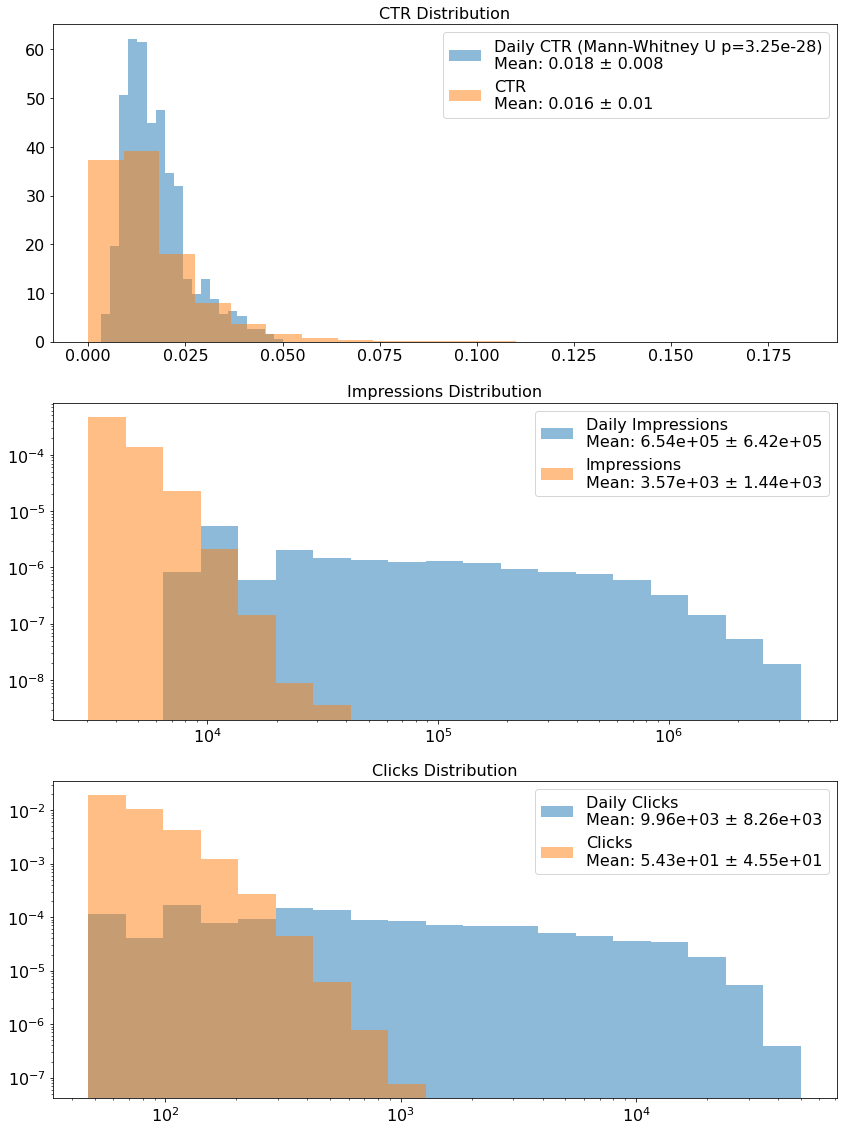

In [71]:
fig, axs = plt.subplots(3, 1, figsize=(12, 16), gridspec_kw={'height_ratios': [1, 1, 1]})

# Adjust font sizes for better readability
plt.rc('font', size=16)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
plt.rc('legend', fontsize=16)

# Histogram for ctr
axs[0].hist(df_daily_agg['daily_ctr'], bins=20, density=True, alpha=0.5,  # Increased number of bins
            label=f"Daily CTR (Mann-Whitney U p={ctr_p_value:.2e})\nMean: {np.round(df_daily_agg_means['daily_ctr'],3)} ± {np.round(df_daily_agg_stds['daily_ctr'],3)}")
axs[0].hist(df['ctr'], bins=20, density=True, alpha=0.5,  # Increased number of bins
            label=f"CTR\nMean: {np.round(df_means['ctr'],3)} ± {np.round(df_stds['ctr'],2)}")
axs[0].set_title('CTR Distribution')
axs[0].legend()

# Histogram for impressions with log binning
log_bins_imp = np.logspace(np.log10(df_daily_agg['daily_impressions'].min()), np.log10(df_daily_agg['daily_impressions'].max()), 20)  # Increased number of bins
axs[1].hist(df_daily_agg['daily_impressions'], bins=log_bins_imp, density=True, alpha=0.5, 
            label=f"Daily Impressions\nMean: {df_daily_agg_means['daily_impressions']:.2e} ± {df_daily_agg_stds['daily_impressions']:.2e}")
axs[1].hist(df['impressions'], bins=log_bins_imp, density=True, alpha=0.5, 
            label=f"Impressions\nMean: {df_means['impressions']:.2e} ± {df_stds['impressions']:.2e}")
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_title('Impressions Distribution')
axs[1].legend()

# Histogram for clicks with log binning
log_bins_clicks = np.logspace(np.log10(df_daily_agg['daily_clicks'].min()), np.log10(df_daily_agg['daily_clicks'].max()), 20)  # Increased number of bins
axs[2].hist(df_daily_agg['daily_clicks'], bins=log_bins_clicks, density=True, alpha=0.5, 
            label=f"Daily Clicks\nMean: {df_daily_agg_means['daily_clicks']:.2e} ± {df_daily_agg_stds['daily_clicks']:.2e}")
axs[2].hist(df['clicks'], bins=log_bins_clicks, density=True, alpha=0.5, 
            label=f"Clicks\nMean: {df_means['clicks']:.2e} ± {df_stds['clicks']:.2e}")
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_title('Clicks Distribution')
axs[2].legend()

# Adjust layout
plt.tight_layout()
plt.savefig('individual_daily_measures_distributions_stacked.pdf', format='pdf', bbox_inches='tight', dpi=1200)
plt.show()

In [42]:
import scipy
# Function to calculate Spearman correlations with p-values and significance levels
def spearman_corr_with_significance(df):
    cols = df.columns
    corr_matrix = pd.DataFrame(index=cols, columns=cols)

    for col1 in cols:
        for col2 in cols:
            corr, p_value = scipy.stats.spearmanr(df[col1], df[col2])
            # Determine the number of asterisks for significance level
            if p_value < 0.001:
                sig = '***'
            elif p_value < 0.01:
                sig = '**'
            elif p_value < 0.05:
                sig = '*'
            else:
                sig = ''
            
            corr_matrix.at[col1, col2] = f"{round(corr, 3)}{sig}"
    
    return corr_matrix

# Calculate Spearman correlations with significance for daily data
spearman_daily_corr = spearman_corr_with_significance(df_daily_agg[['daily_ctr', 'daily_impressions', 'daily_clicks']])

# Calculate Spearman correlations with significance for overall data
spearman_overall_corr = spearman_corr_with_significance(df[['ctr', 'impressions', 'clicks']])

spearman_daily_corr

,daily_ctr,daily_impressions,daily_clicks
daily_ctr,1.0***,-0.231***,0.135***
daily_impressions,-0.231***,1.0***,0.91***
daily_clicks,0.135***,0.91***,1.0***


,ctr,impressions,clicks
ctr,1.0***,-0.13***,0.889***
impressions,-0.13***,1.0***,0.287***
clicks,0.889***,0.287***,1.0***


In [40]:
spearman_overall_corr


,ctr,impressions,clicks
ctr,1.0***,-0.13***,0.889***
impressions,-0.13***,1.0***,0.287***
clicks,0.889***,0.287***,1.0***


# Events and peaks

In [77]:
import numpy as np
from scipy.signal import find_peaks

measure = 'daily_ctr'

# Calculate a rolling mean with a window of 30 days for df_daily_agg
df_daily_agg['rolling_mean'] = df_daily_agg[measure].rolling(window=30, min_periods=1, center=True).mean()

# Define a function to find peaks (maxima) and troughs (minima) in df_daily_agg
def find_peaks_troughs(data, col, distance=1, prominence=1):
    # Find peaks in df_daily_agg
    peaks, _ = find_peaks(data[col], distance=distance, prominence=prominence)
    # Find troughs in df_daily_agg by inverting the data
    troughs, _ = find_peaks(-data[col], distance=distance, prominence=prominence)
    return peaks, troughs

# Using the function to find peaks and troughs in the 'impressions' column of df_daily_agg
# Adjusting distance and prominence according to the data in df_daily_agg
peaks, troughs = find_peaks_troughs(df_daily_agg, measure, distance=1, prominence=(df_daily_agg[measure].max() * 0.2))

# Mark the peaks and troughs in the df_daily_agg DataFrame
df_daily_agg['peak'] = np.where(df_daily_agg.index.isin(peaks), df_daily_agg[measure], np.nan)
df_daily_agg['trough'] = np.where(df_daily_agg.index.isin(troughs), df_daily_agg[measure], np.nan)

# Assuming there are 'date' and 'week_start' columns in your df_daily_agg DataFrame for the following operations
# If not, you might need to adjust these lines according to your actual DataFrame structure
peaks_df = df_daily_agg.dropna(subset=['peak'])[['created_at', measure]]
troughs_df = df_daily_agg.dropna(subset=['trough'])[['created_at', measure]]

# Sort and reset index for peaks and troughs DataFrames
peaks_df.reset_index(drop=True, inplace=True)
peaks_df = peaks_df.sort_values(by='created_at', ascending=False)
troughs_df.reset_index(drop=True, inplace=True)
troughs_df = troughs_df.sort_values(by='created_at', ascending=False)

In [78]:

peak_events = pd.merge(peaks_df, df_h_events, left_on='created_at', right_on='date', how='inner')
peak_events['event_text'] = peak_events['event_text'].replace(',',' ')

trough_events = pd.merge(troughs_df,df_h_events, left_on='created_at', right_on='date', how='inner')
print('Peak events')
print(peak_events)
print()
print('Trough events')
print(trough_events)

Peak events
  created_at  daily_ctr       date  id  importance    frequency  happiness  \
0 2013-12-31   0.040285 2013-12-31  91         -30  150556230.0      6.125   
1 2013-04-15   0.024703 2013-04-15  78         100  163478545.0      5.891   

  week_start                   event_text  
0 2013-12-30             New Year's\n Eve  
1 2013-04-15  Bombing at\nBoston Marathon  

Trough events
  created_at  daily_ctr       date   id  importance    frequency  happiness  \
0 2015-01-04   0.003323 2015-01-04  118         -30  139112977.0      6.034   
1 2014-08-16   0.003855 2014-08-16  106         -70  127893713.0      6.056   
2 2014-05-11   0.009167 2014-05-11   96         -30  141641671.0      6.145   
3 2013-12-24   0.022599 2013-12-24   89         -30  142703405.0      6.205   
4 2013-07-14   0.022112 2013-07-14   85         -30  152417419.0      5.931   

  week_start                       event_text  
0 2014-12-29           Death of\nStuart Scott  
1 2014-08-11  Protests in\nFerguson

In [79]:
# Raw count of peak events
peak_event_count = len(peak_events)
# Raw count of trough events
trough_event_count = len(trough_events)
# Total number of events in df_h_events
total_events = len(df_h_events)

# Print the results
print(f'Number of annotated events from Hedonometer corresponding to daily ctr peaks: {peak_event_count}')
print(f'Number of annotated events from Hedonometer corresponding to daily ctr troughs: {trough_event_count}')
print(f'Total number of events in df_h_events: {total_events}')


Number of annotated events from Hedonometer corresponding to daily ctr peaks: 2
Number of annotated events from Hedonometer corresponding to daily ctr troughs: 5
Total number of events in df_h_events: 49


In [86]:
print('Total number of days',len(df_daily_agg))

Total number of days 827


In [91]:
print('Total number of peaks',len(peaks_df), 'and troughs',len(troughs))

Total number of peaks 47 and troughs 47


In [81]:
len(troughs_df)

47

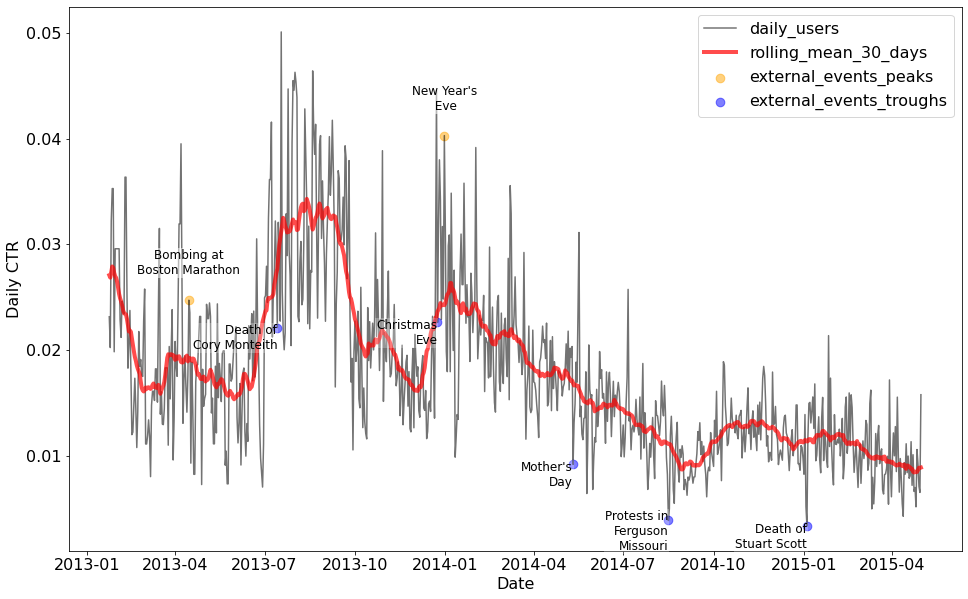

In [82]:
# Filter peaks and troughs based on events
filtered_peaks_df = peaks_df[peaks_df['created_at'].isin(peak_events['created_at'])]
filtered_troughs_df = troughs_df[troughs_df['created_at'].isin(trough_events['created_at'])]
font_size = 12

plt.figure(figsize=(16,10))
plt.plot(df_daily_agg['created_at'], df_daily_agg[measure], color='black', alpha=0.55, label='daily_users')
plt.plot(df_daily_agg['created_at'], df_daily_agg['rolling_mean'], color='red', alpha=0.7, lw=4, label='rolling_mean_30_days')
plt.scatter(filtered_peaks_df['created_at'], filtered_peaks_df[measure], color='orange', alpha=0.5, label='external_events_peaks', s=75)
plt.scatter(filtered_troughs_df['created_at'], filtered_troughs_df[measure], color='blue', alpha=0.5, label='external_events_troughs', s=75)
plt.ylabel(measure, fontsize=16)
plt.xlabel('Created At', fontsize=16)
plt.legend()

peak_offset = 0.0035
trough_offset = 0.001
ha='center'
for i in range(len(peak_events)):
    plt.text(peak_events.at[i,'created_at'],peak_events.at[i,'daily_ctr'] + peak_offset,peak_events.at[i,'event_text'],bbox={'facecolor':'white','alpha':0.5,'edgecolor':'none','pad':1},
ha='center', va='center', fontsize=font_size)

for i in range(len(trough_events)):
    if i < len(trough_events) - 2:
        trough_offset = 0.001
        ha = 'right'
    plt.text(trough_events.at[i,'created_at'],trough_events.at[i,'daily_ctr'] - trough_offset,trough_events.at[i,'event_text'],bbox={'facecolor':'white','alpha':0.25,'edgecolor':'none','pad':1},
ha=ha, va='center', fontsize=font_size)
plt.ylabel('Daily CTR');
plt.xlabel('Date')
plt.savefig('daily_ctr_events.pdf', format='pdf', bbox_inches='tight', dpi=1200)


# Appendix

Text(0.5, 1.0, 'Hedonometer')

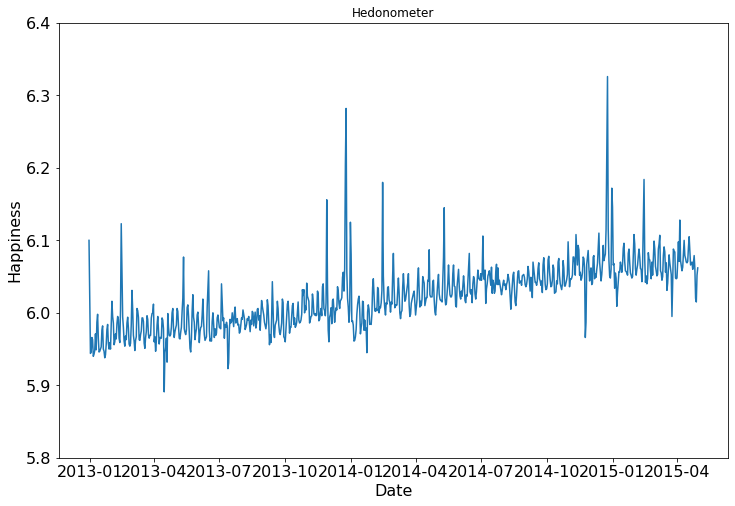

In [69]:
plt.figure(figsize=(12,8))
plt.plot(df_hedonometer['date'],df_hedonometer['happiness'])
#plt.text(first_date, first_happiness, first_name,bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
#          ha='center', va='center')
plt.ylabel("Happiness")
plt.ylim(5.8,6.4)
plt.xlabel('Date');
plt.title('Hedonometer')

In [ ]:
# Random selection and visual inspection of data